In [1]:
# importing packages and modules
import numpy as np
#import autograd.numpy as jnp
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1, dglm_hmm2
from scipy.stats import multivariate_normal, norm
#from autograd import value_and_grad

colormap = ['rebeccapurple','teal','darkturquoise','springgreen']
sns.set_context("talk")

ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [2]:
exampleSubject = 'ibl_witten_15'

In [3]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 5

D = 4 # number of features
sessStop = -1 # last session to use in fitting

K = 3
truepi = np.ones((K))/K

Text(762.4583333333334, 0.5, 'Delta Test Ll (per trial)')

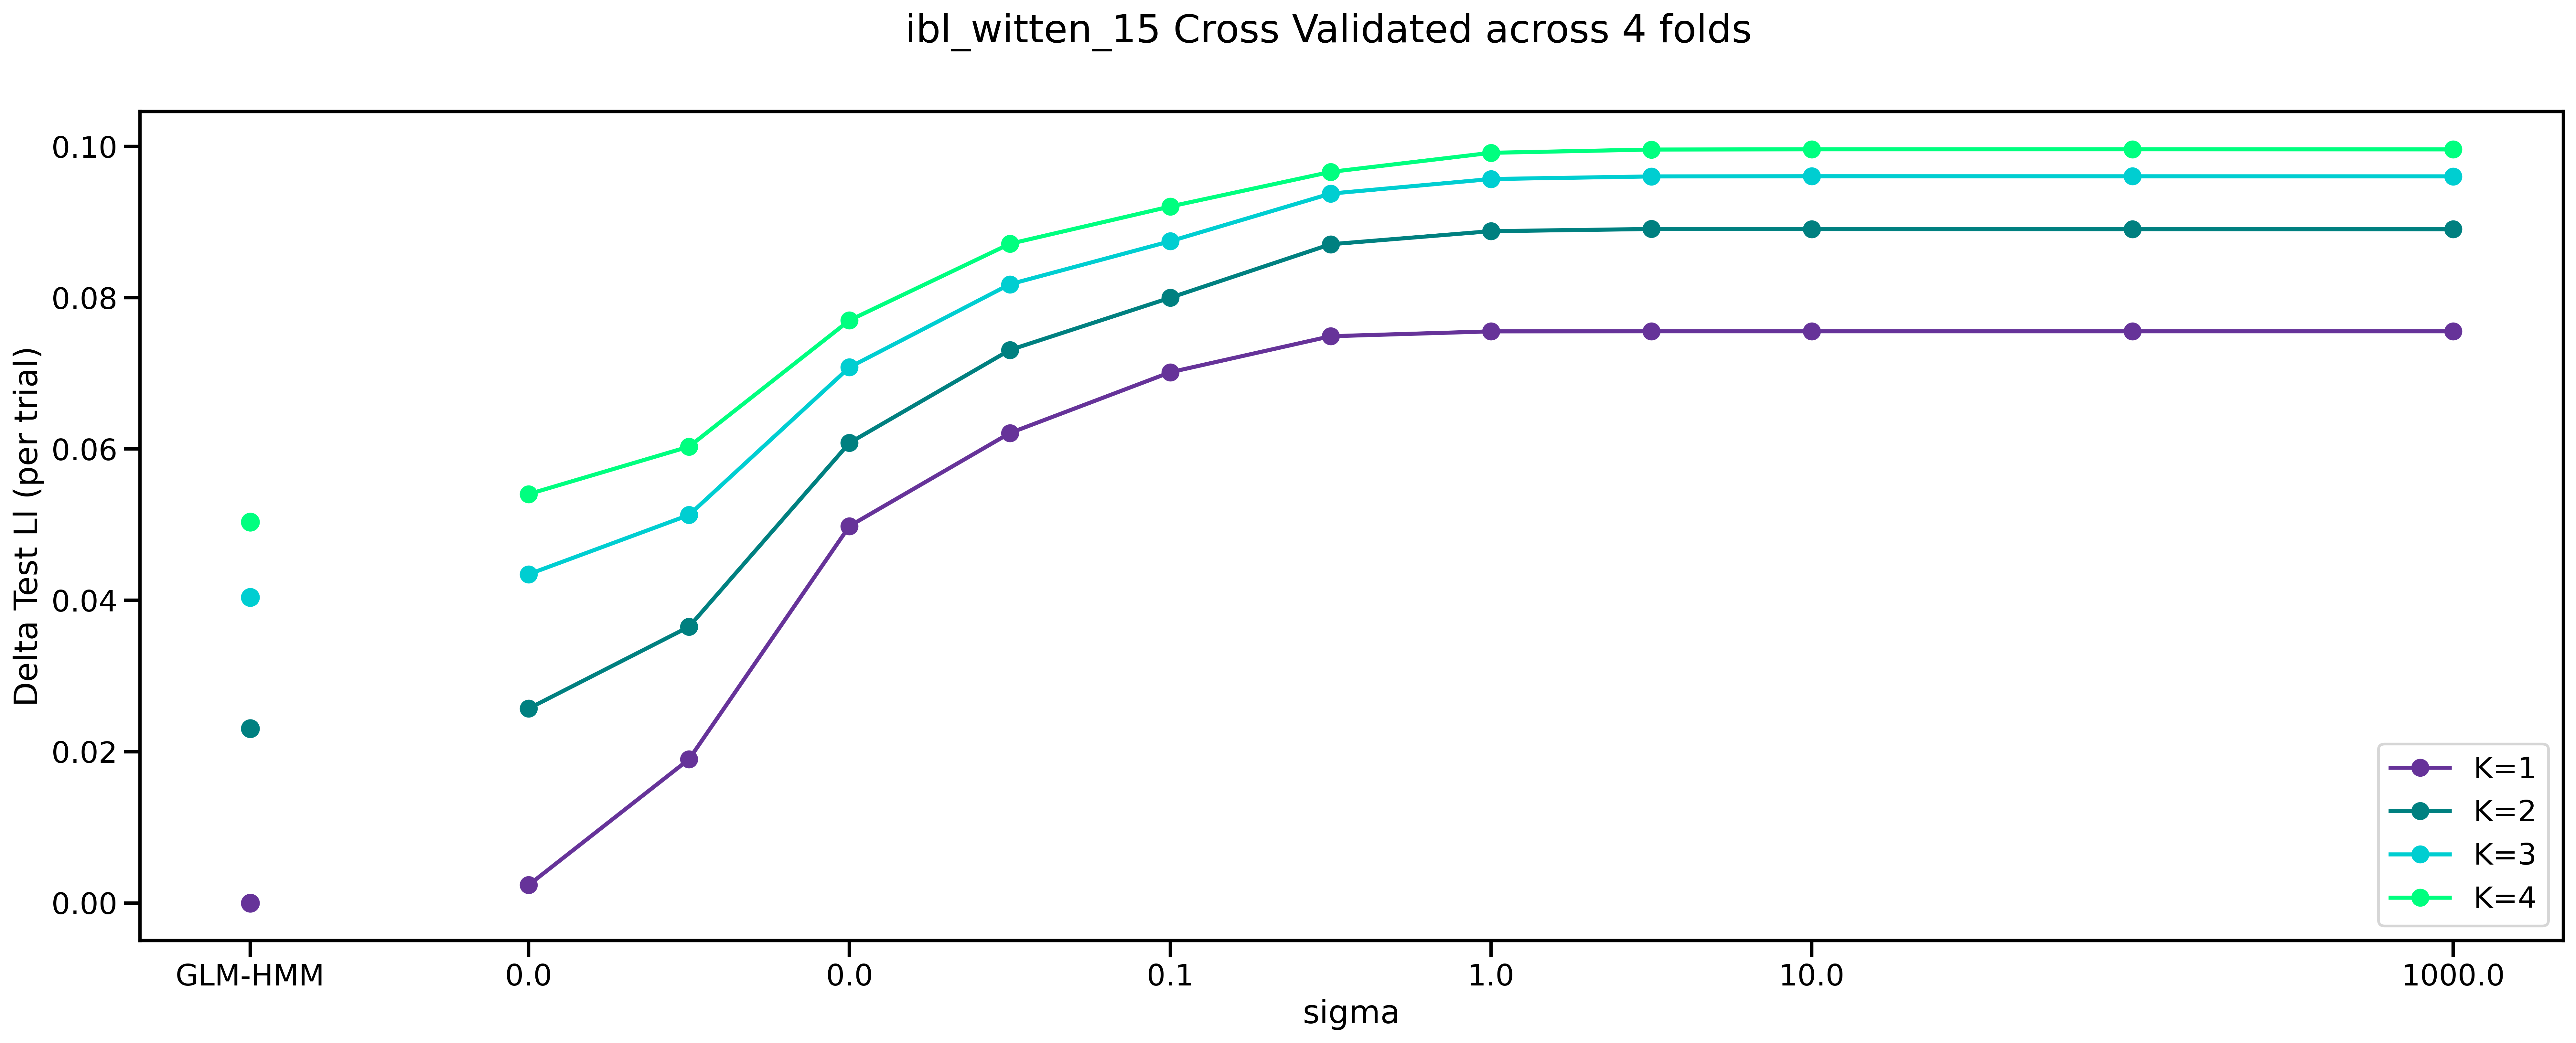

In [4]:
testLlAll = np.empty((4, len(sigmaList)))
bestTestLl = np.zeros((4,11))
bestTestAccuracy = np.zeros((4,11))

testLl = []
testAccuracy = []
avgTestLl = []
avgTestAccuracy = []
for K in [1,2,3,4]:
    for fold in range(0, splitFolds):
        testLl.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_testLl_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        testAccuracy.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_testAccuracy_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    avgTestLl.append(np.mean(testLl[:],axis=0))
    avgTestAccuracy.append(np.mean(testAccuracy[:],axis=0))
avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to GLM-HMM sigma=0 K=1
avgTestAccuracy = [x - avgTestAccuracy[0][0] for x in avgTestAccuracy]
    
for K in [1,2,3,4]:
    testLlAll[K-1] = avgTestLl[K-1]

bestSigmaInd = 7 # Choosing best sigma index across animals
for K in [1,2,3,4]:
    bestTestLl[K-1] = avgTestLl[K-1][bestSigmaInd] - avgTestLl[0][bestSigmaInd] # delta
    bestTestAccuracy[K-1] = avgTestAccuracy[K-1][bestSigmaInd] - avgTestAccuracy[0][bestSigmaInd] # delta

# # Plotting each fold indiviudally for per-animal plots
# fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
# fig.suptitle(f'{subject}')
# for K in range(1,5):
#     for fold in range(0, splitFolds):
#         plot_testLl_CV_sigma(testLl[splitFolds*(K-1)+fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=colormap[K-1], axes=axes)
    
# Plotting delta test ll averaged across folds for per-animal plots
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{exampleSubject} Cross Validated across 4 folds')
fig.tight_layout()
for K in range(1,5):
    plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
axes.set_ylabel("Delta Test Ll (per trial)")

Text(62.45833333333332, 0.5, '  test log-like (per trial)')

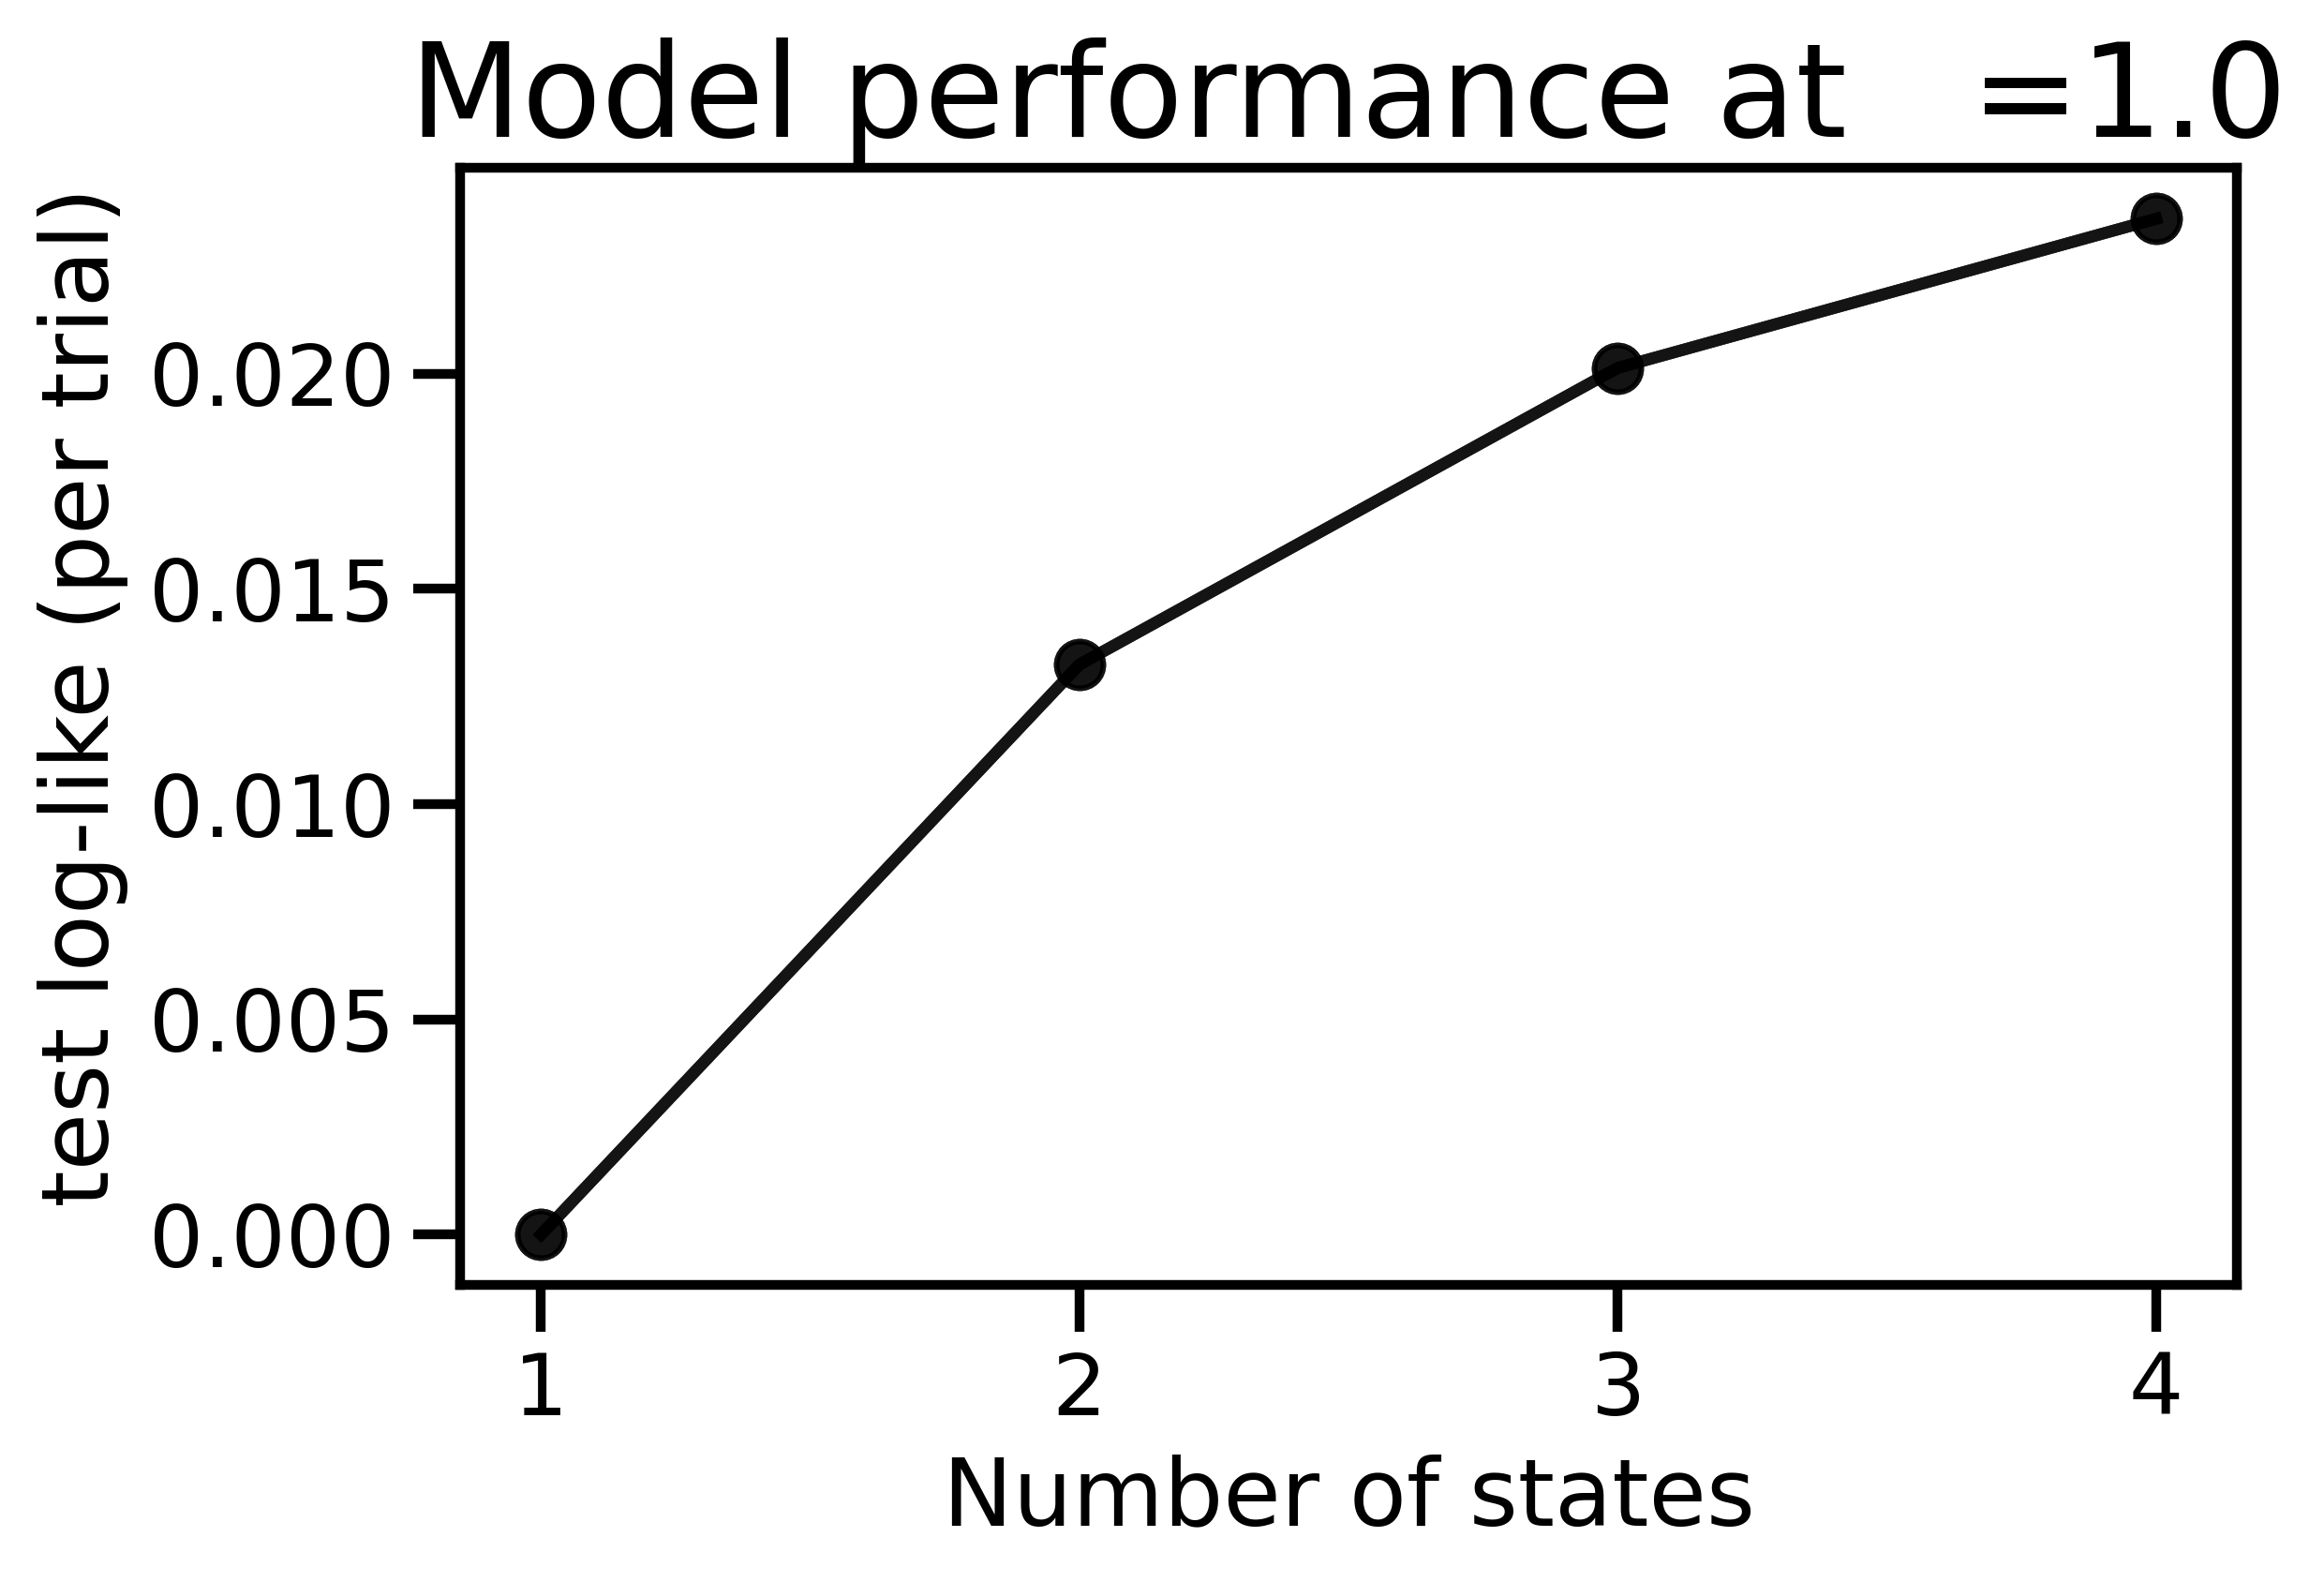

In [77]:
fig, axes = plt.subplots(1, figsize=(6,4), dpi=400)
fig.tight_layout()
axes.plot([1,2,3,4],bestTestLl[:],'-o', color='black',alpha=0.2)
axes.set_xticks([1,2,3,4])
axes.set_title(f'Model performance at   ={np.round(sigmaList[bestSigmaInd],2)}', fontsize=25)
axes.set_xlabel('Number of states')
axes.set_ylabel('  test log-like (per trial)')

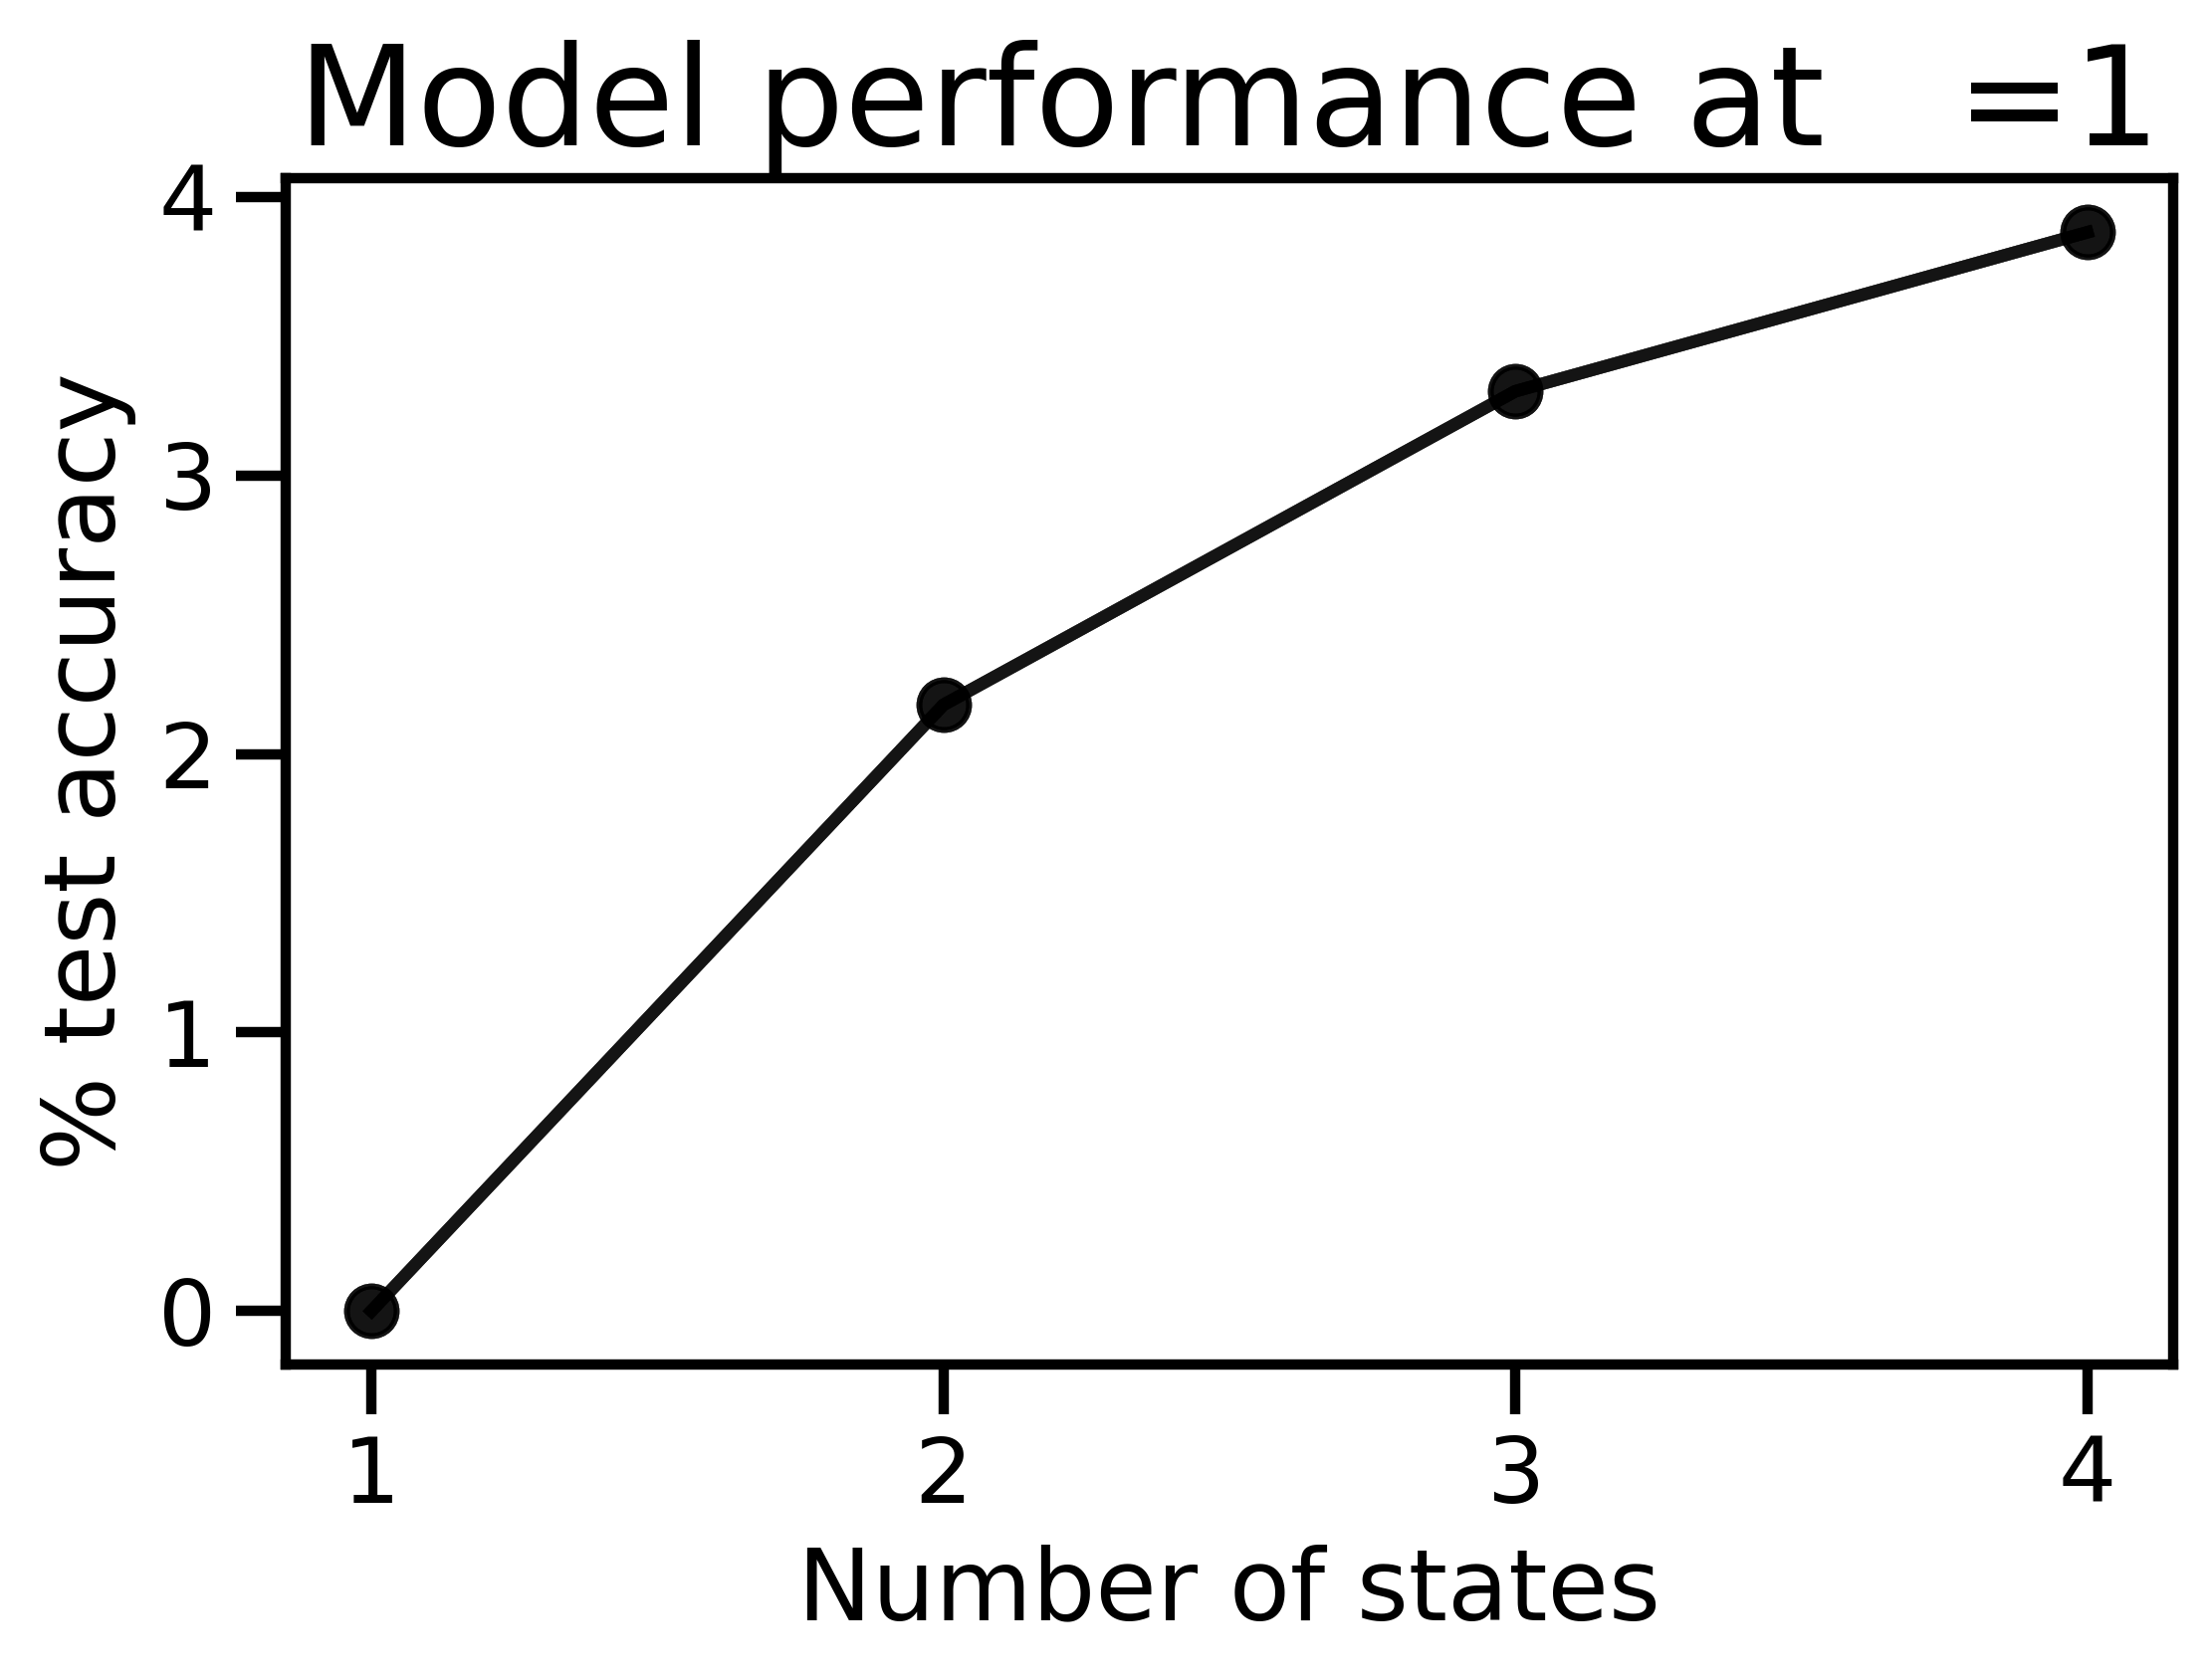

In [49]:
bestSigmaInd = 7 # Sigma to look at parameters for
fig, axes = plt.subplots(1,figsize=(6,4), dpi=400)
fig.tight_layout()
axes.set_title(f'Model performance at   =1', fontsize=25)
axes.set_xlabel('Number of states')
axes.set_ylabel('% test accuracy')
axes.plot([1,2,3,4],bestTestAccuracy[:],'-o', color='black',alpha=0.2)
axes.set_xticks([1,2,3,4])

Text(0.5, 1.0, 'Recovered weights for 3-state dGLM-HMM on mouse ibl_witten_15')

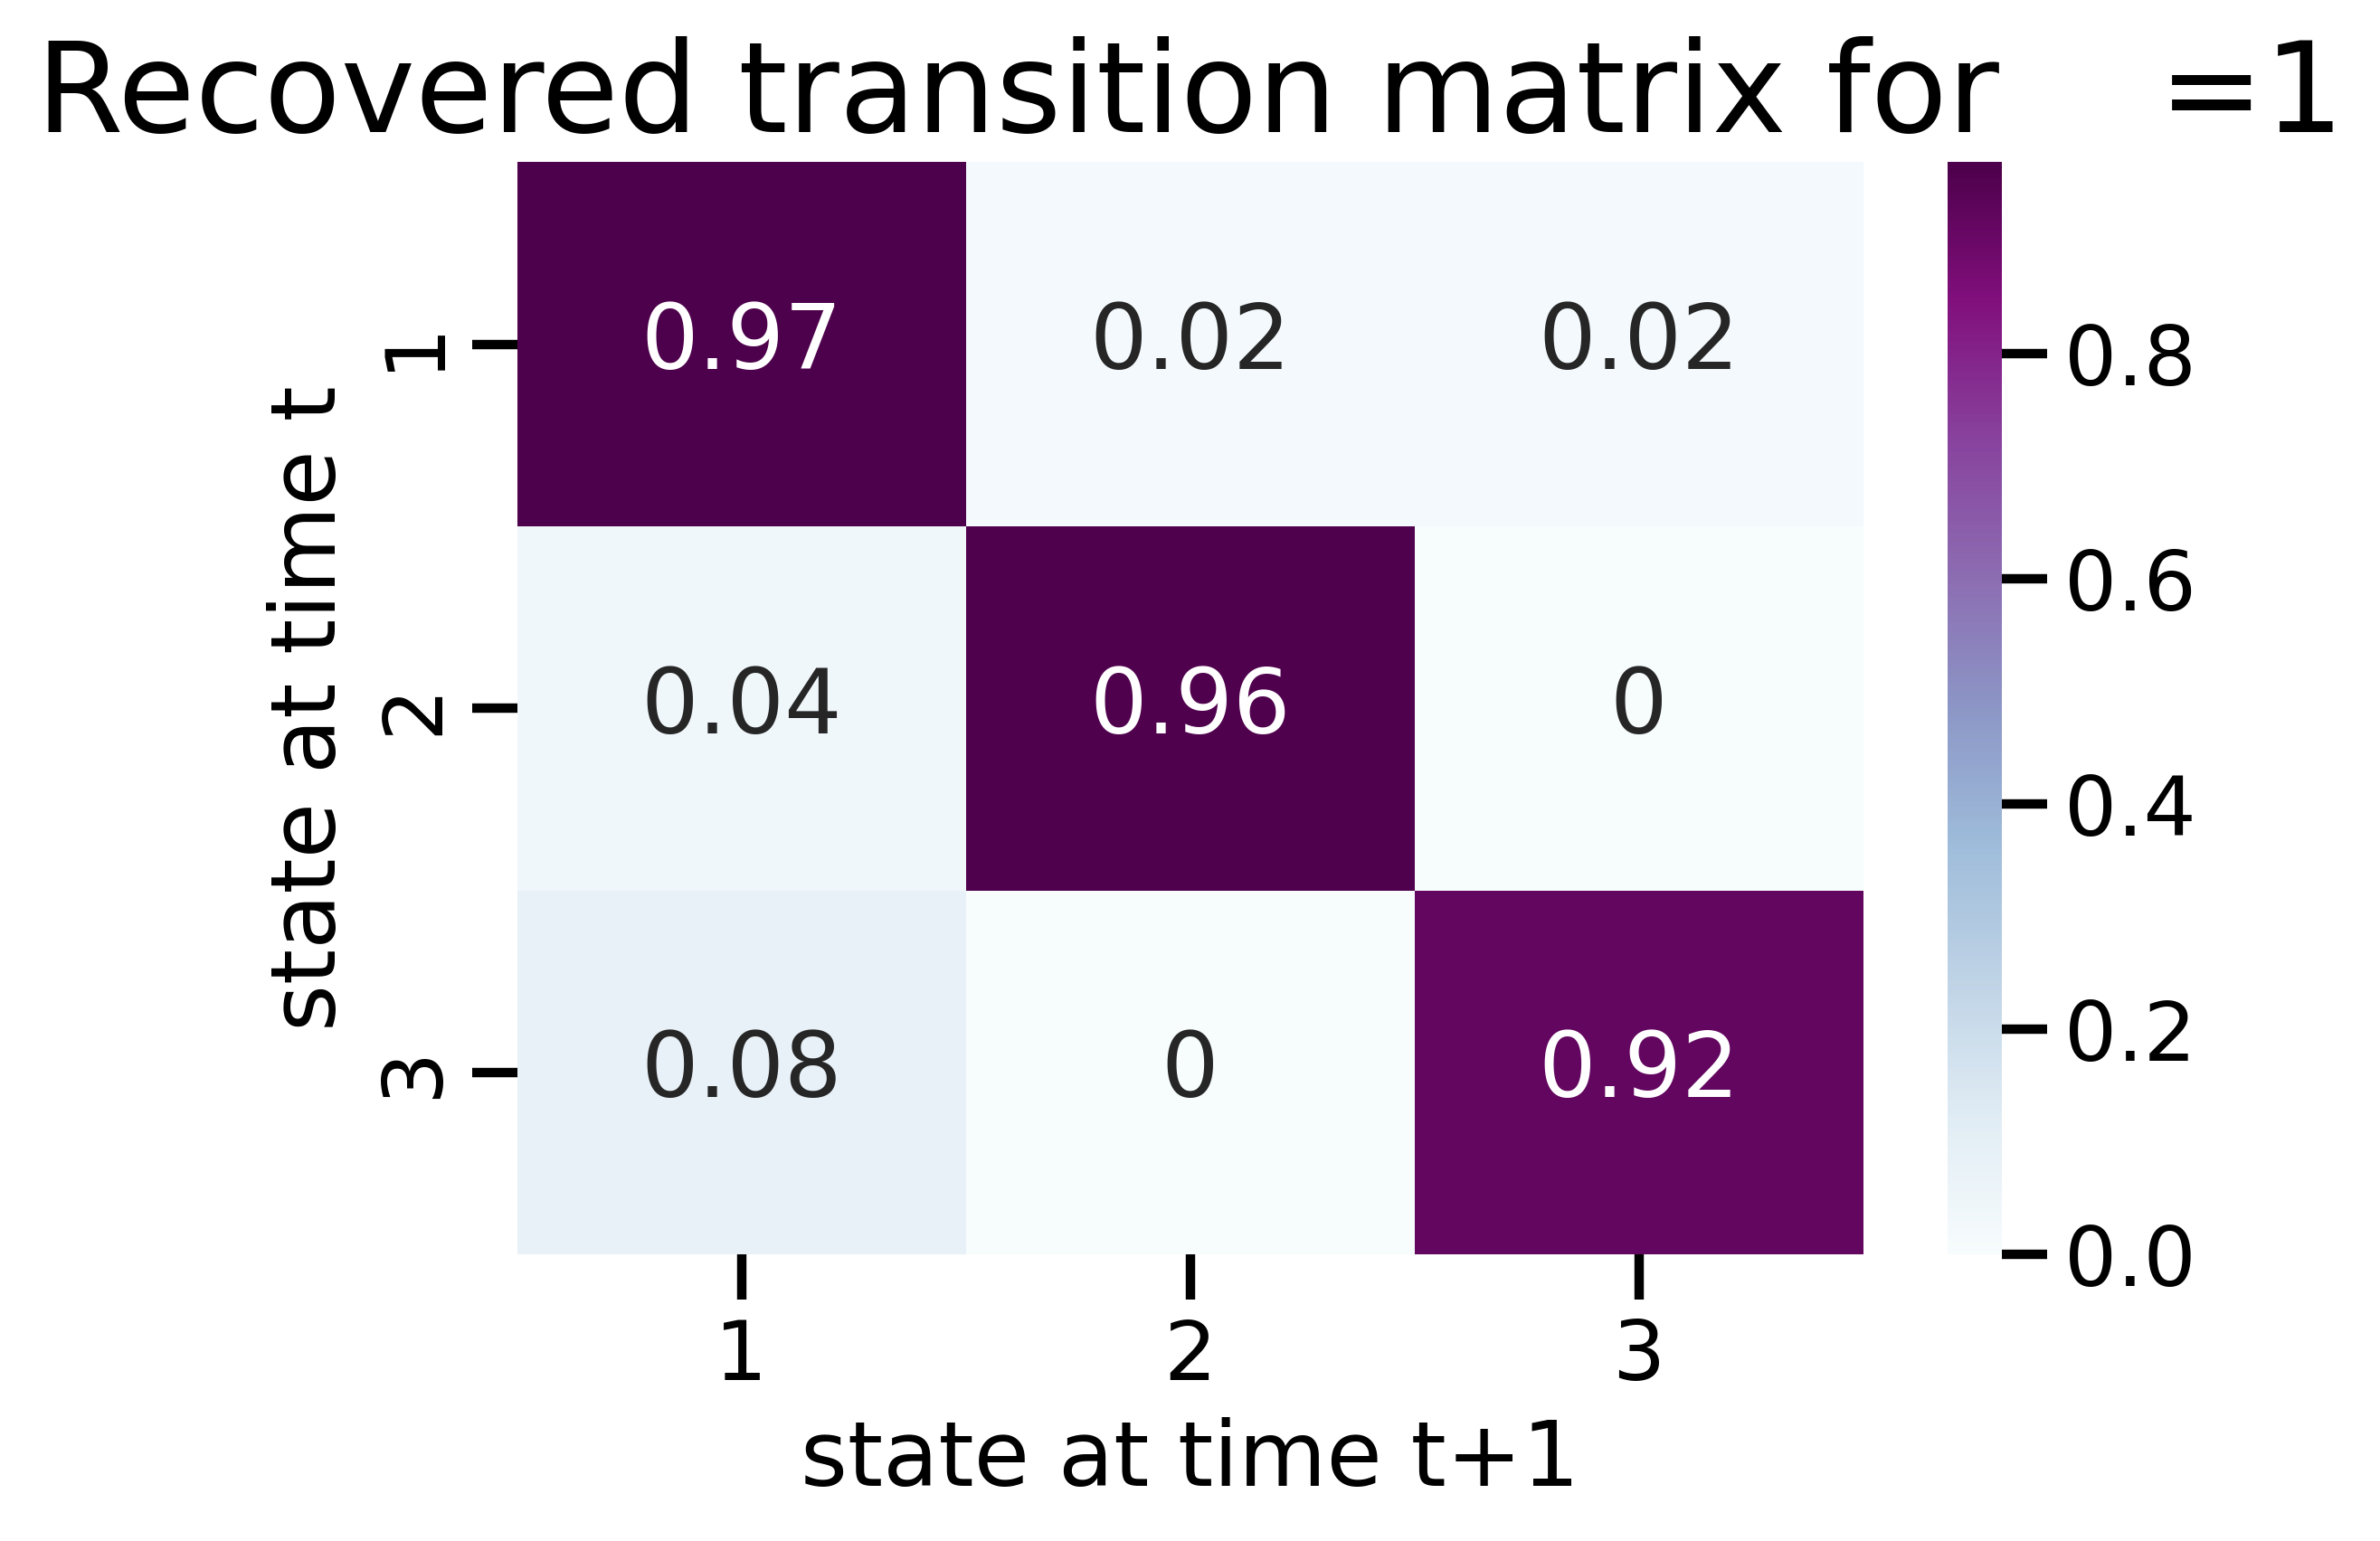

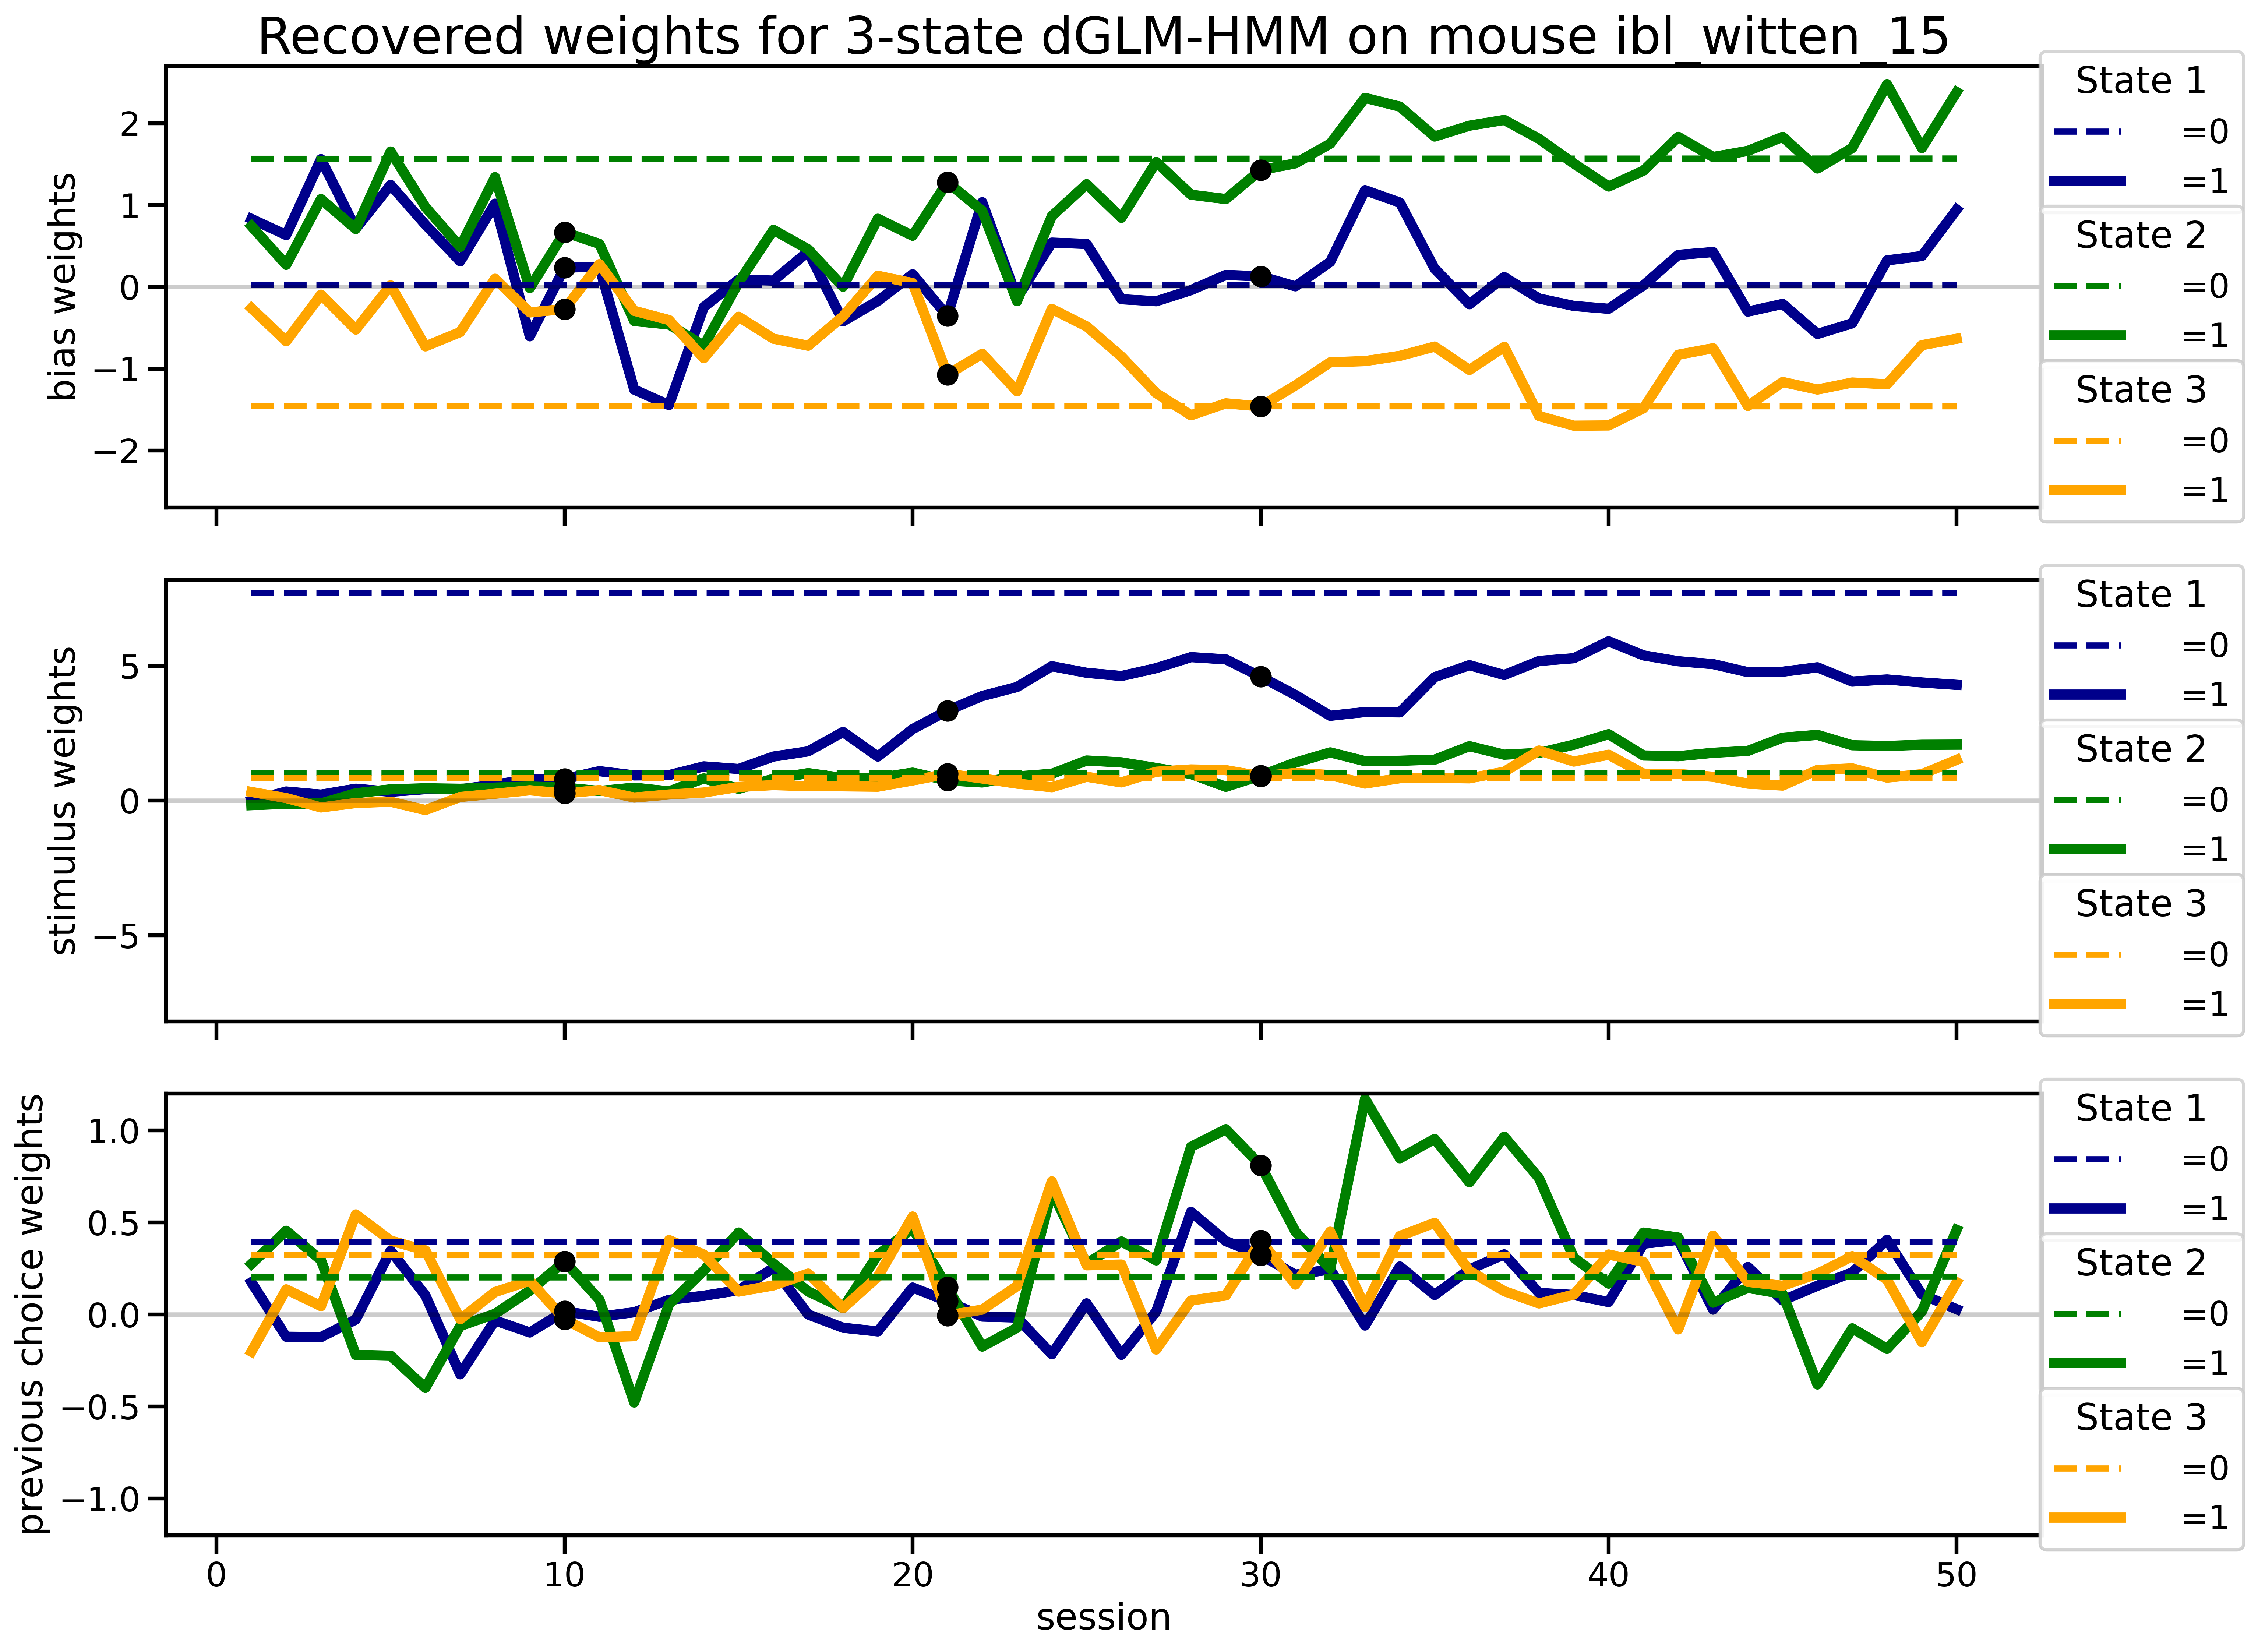

In [79]:
# Plotting Weights
sessionsInterest = [9,20,29]
bestSigmaInd = 7
_, _, sessInd = get_mouse_design(dfAll, exampleSubject, sessStop=sessStop, D=4)

K = 3

allP = []
allW = []
allW0 = []
sns.set_context("talk")

myFeatures = [['bias','stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]


for fold in range(0, splitFolds):
    allP.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_P_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    allW.append(np.load(f'../data_IBL/{exampleSubject}/{exampleSubject}_W_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    allW0.append(allW[fold][1]) # standard GLM-HMM is the same across folds

    # # plotting transition matrix individually 
    # fig, axes = plt.subplots()
    # plot_transition_matrix(allP[fold][bestSigmaInd], sortedStateInd=None) # not sorted

    # # plotting weights for each fold individually
    # fig, axes = plt.subplots(D, 1,figsize=(16,4*D+1), sharex=True)
    # fig.suptitle(f'{subject}: sigma = {np.round(sigmaList[bestSigmaInd],2)} fold {fold}')
    # fig.tight_layout()
    # plotting_weights_per_feature(allW[fold][bestSigmaInd], sessInd, axes, yLim=[[-2.5,2.5],[-6.2,6.2]], colors=colorsStates, labels=myFeatures[D%2], linewidth=5, linestyle='-', sortedStateInd=None)
        
avgP = np.mean(allP[:], axis=0)
avgW = np.mean(allW[:], axis=0)
avgW0 = np.mean(allW0[:], axis=0)

# plotting transition matrix averaged across folds
fig, axes = plt.subplots(dpi=400)
plot_transition_matrix(np.round(avgP[bestSigmaInd],2), title=f'Recovered    =1', sortedStateInd=None) # not sorted
axes.set_title('Recovered transition matrix for    =1', fontsize=25)
            
plotSess = 50
fig, axes = plt.subplots(3, 1,figsize=(14,11), sharex=True, dpi=400)
fig.tight_layout()
yLim=[[-2.7,2.7],[-8.2,8.2],[-1.2,1.2],[-1.2,1.2]]
for d in range(0, 3):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-avgW0[sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=3, alpha=1, linestyle='--', label='   =0', zorder=1)
        axes[d].plot(range(1,plotSess+1),-avgW[bestSigmaInd][sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=5, alpha=1, linestyle='-', label='   =1', zorder=0)
        for s in sessionsInterest:
            axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
    lines = axes[d].get_lines()
    include = [1,2]
    legend1 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.85), title = "State 1")
    include = [3,4]
    legend2 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.5), title = "State 2")
    include = [5,6]
    legend3 = axes[d].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, 0.15), title = "State 3")
    axes[d].add_artist(legend1)
    axes[d].add_artist(legend2)
    axes[d].add_artist(legend3)
    axes[d].set_ylim(yLim[d])
    axes[d].set_ylabel("weights")
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'{myFeatures[D%2][d]} weights')
axes[2].set_xlabel('session')
sns.set_context("talk")
axes[0].set_title('Recovered weights for 3-state dGLM-HMM on mouse '+ str(exampleSubject), fontsize=25)

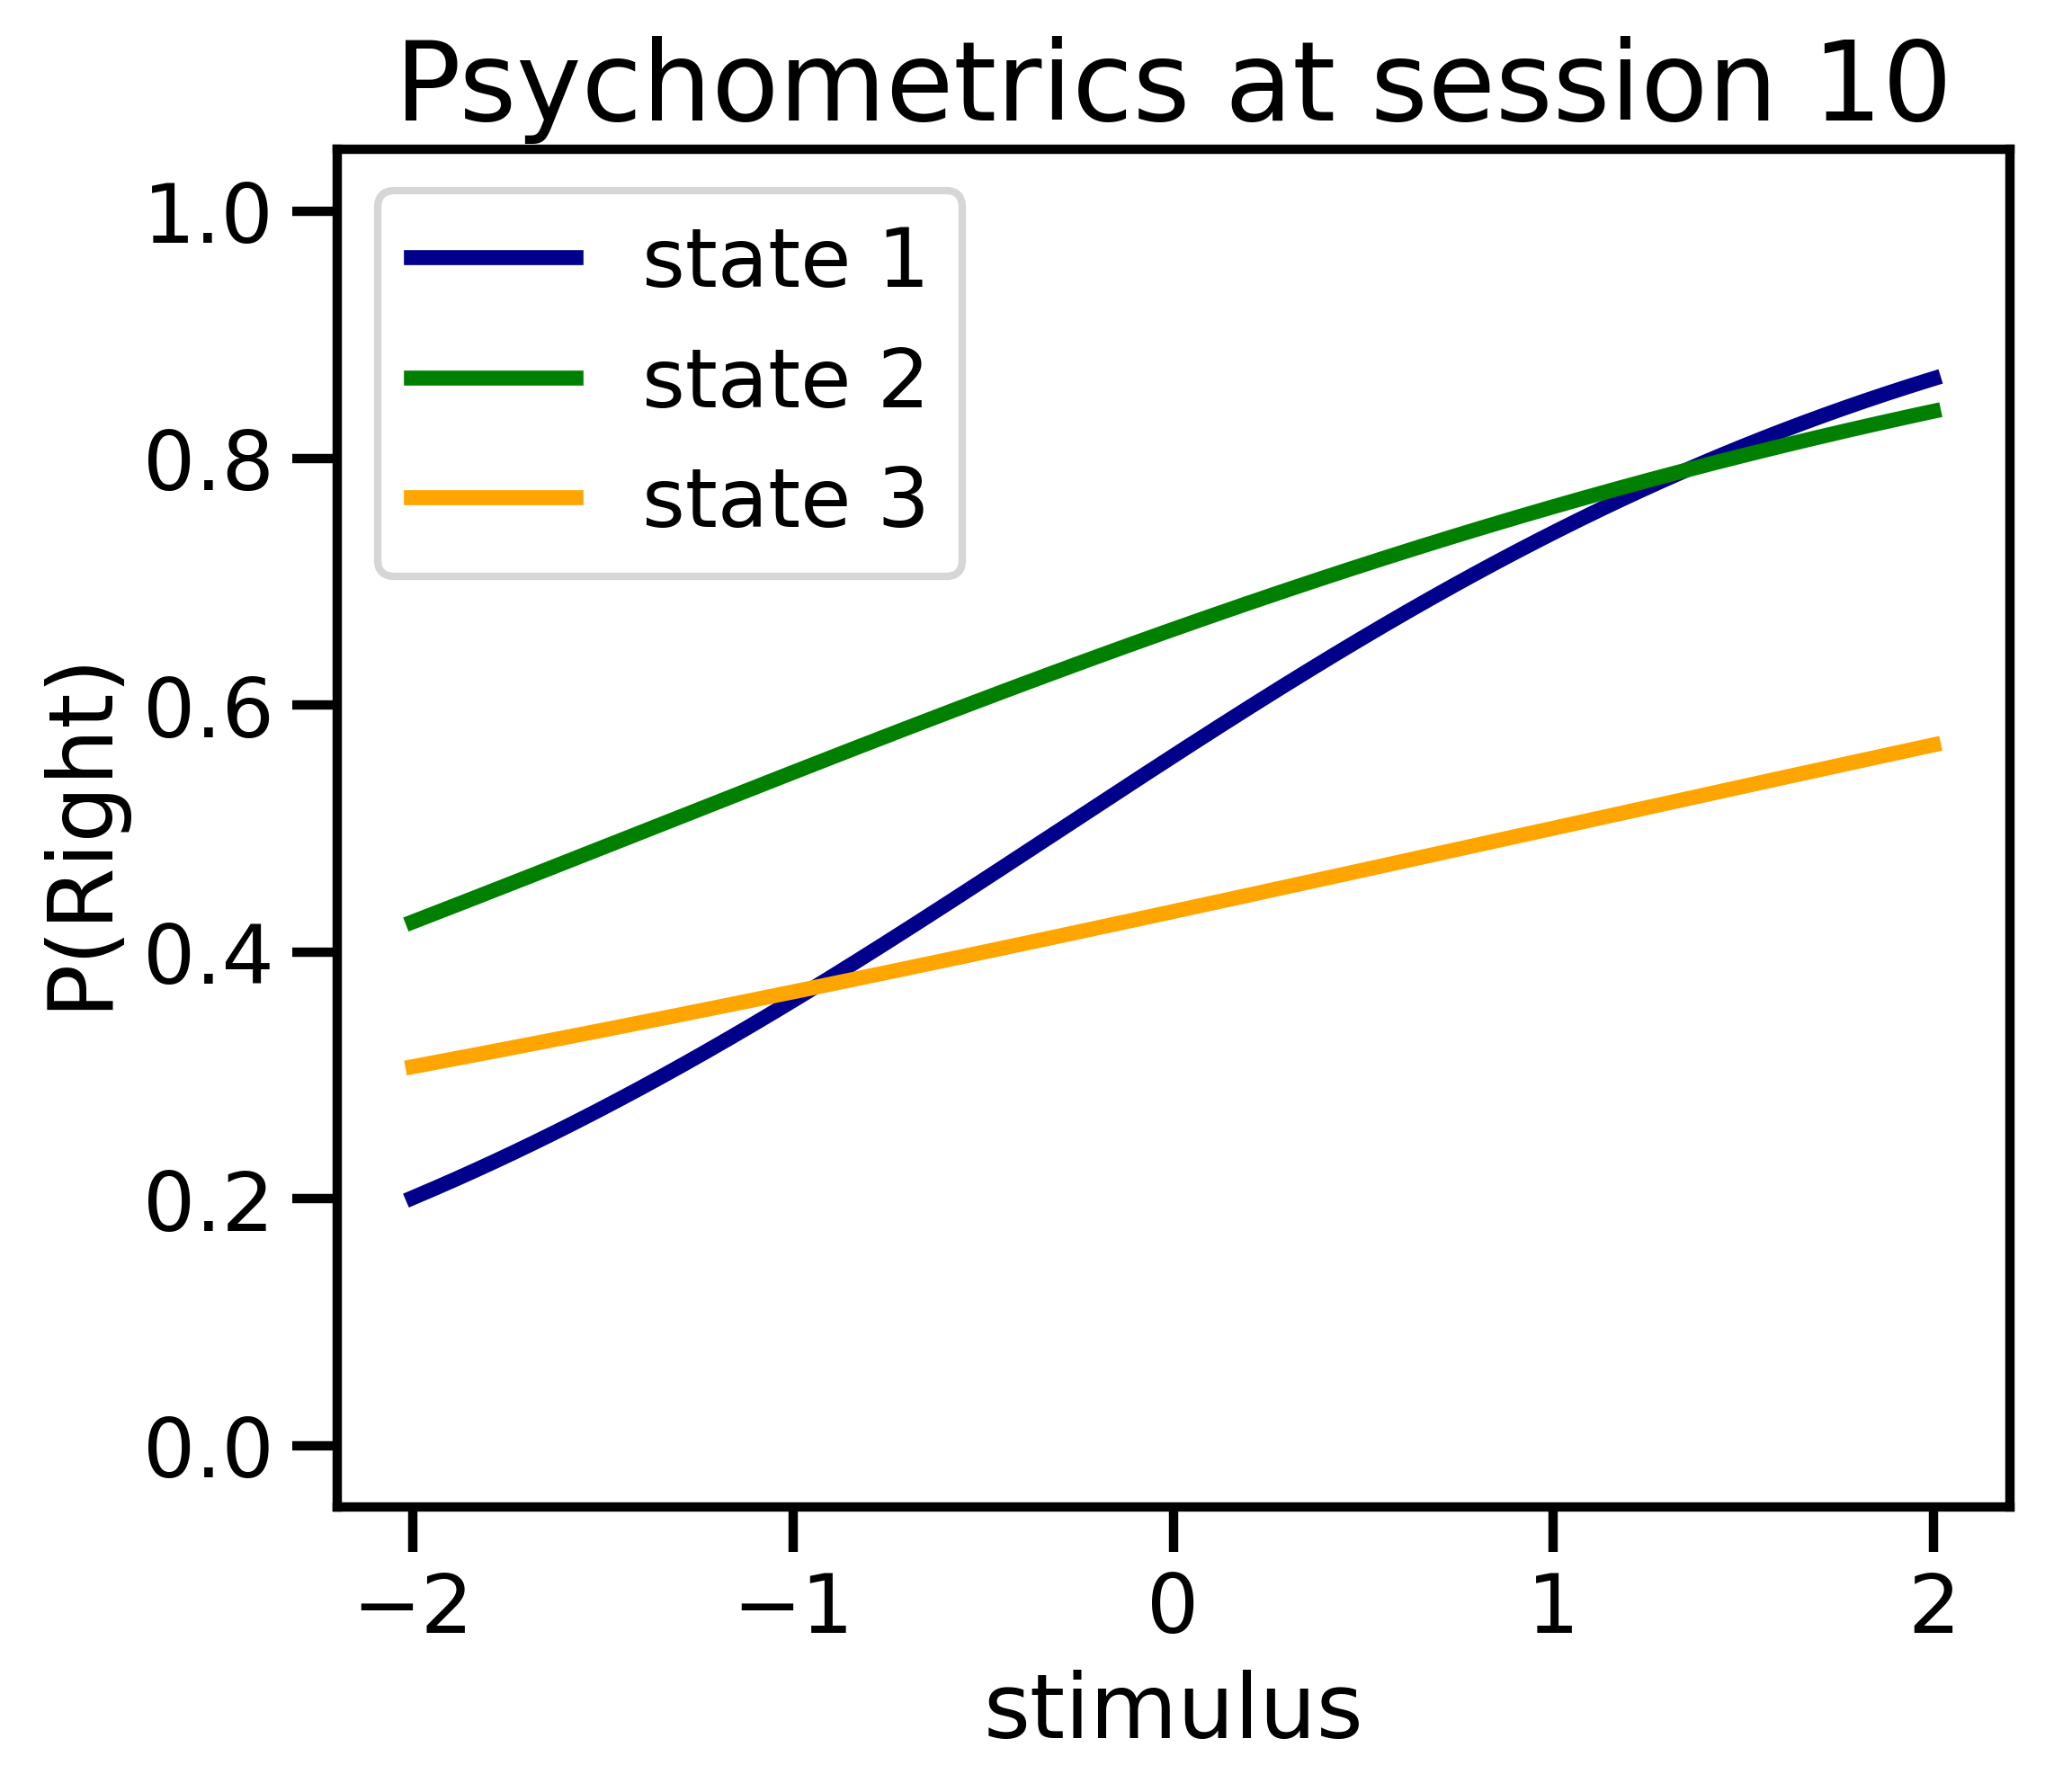

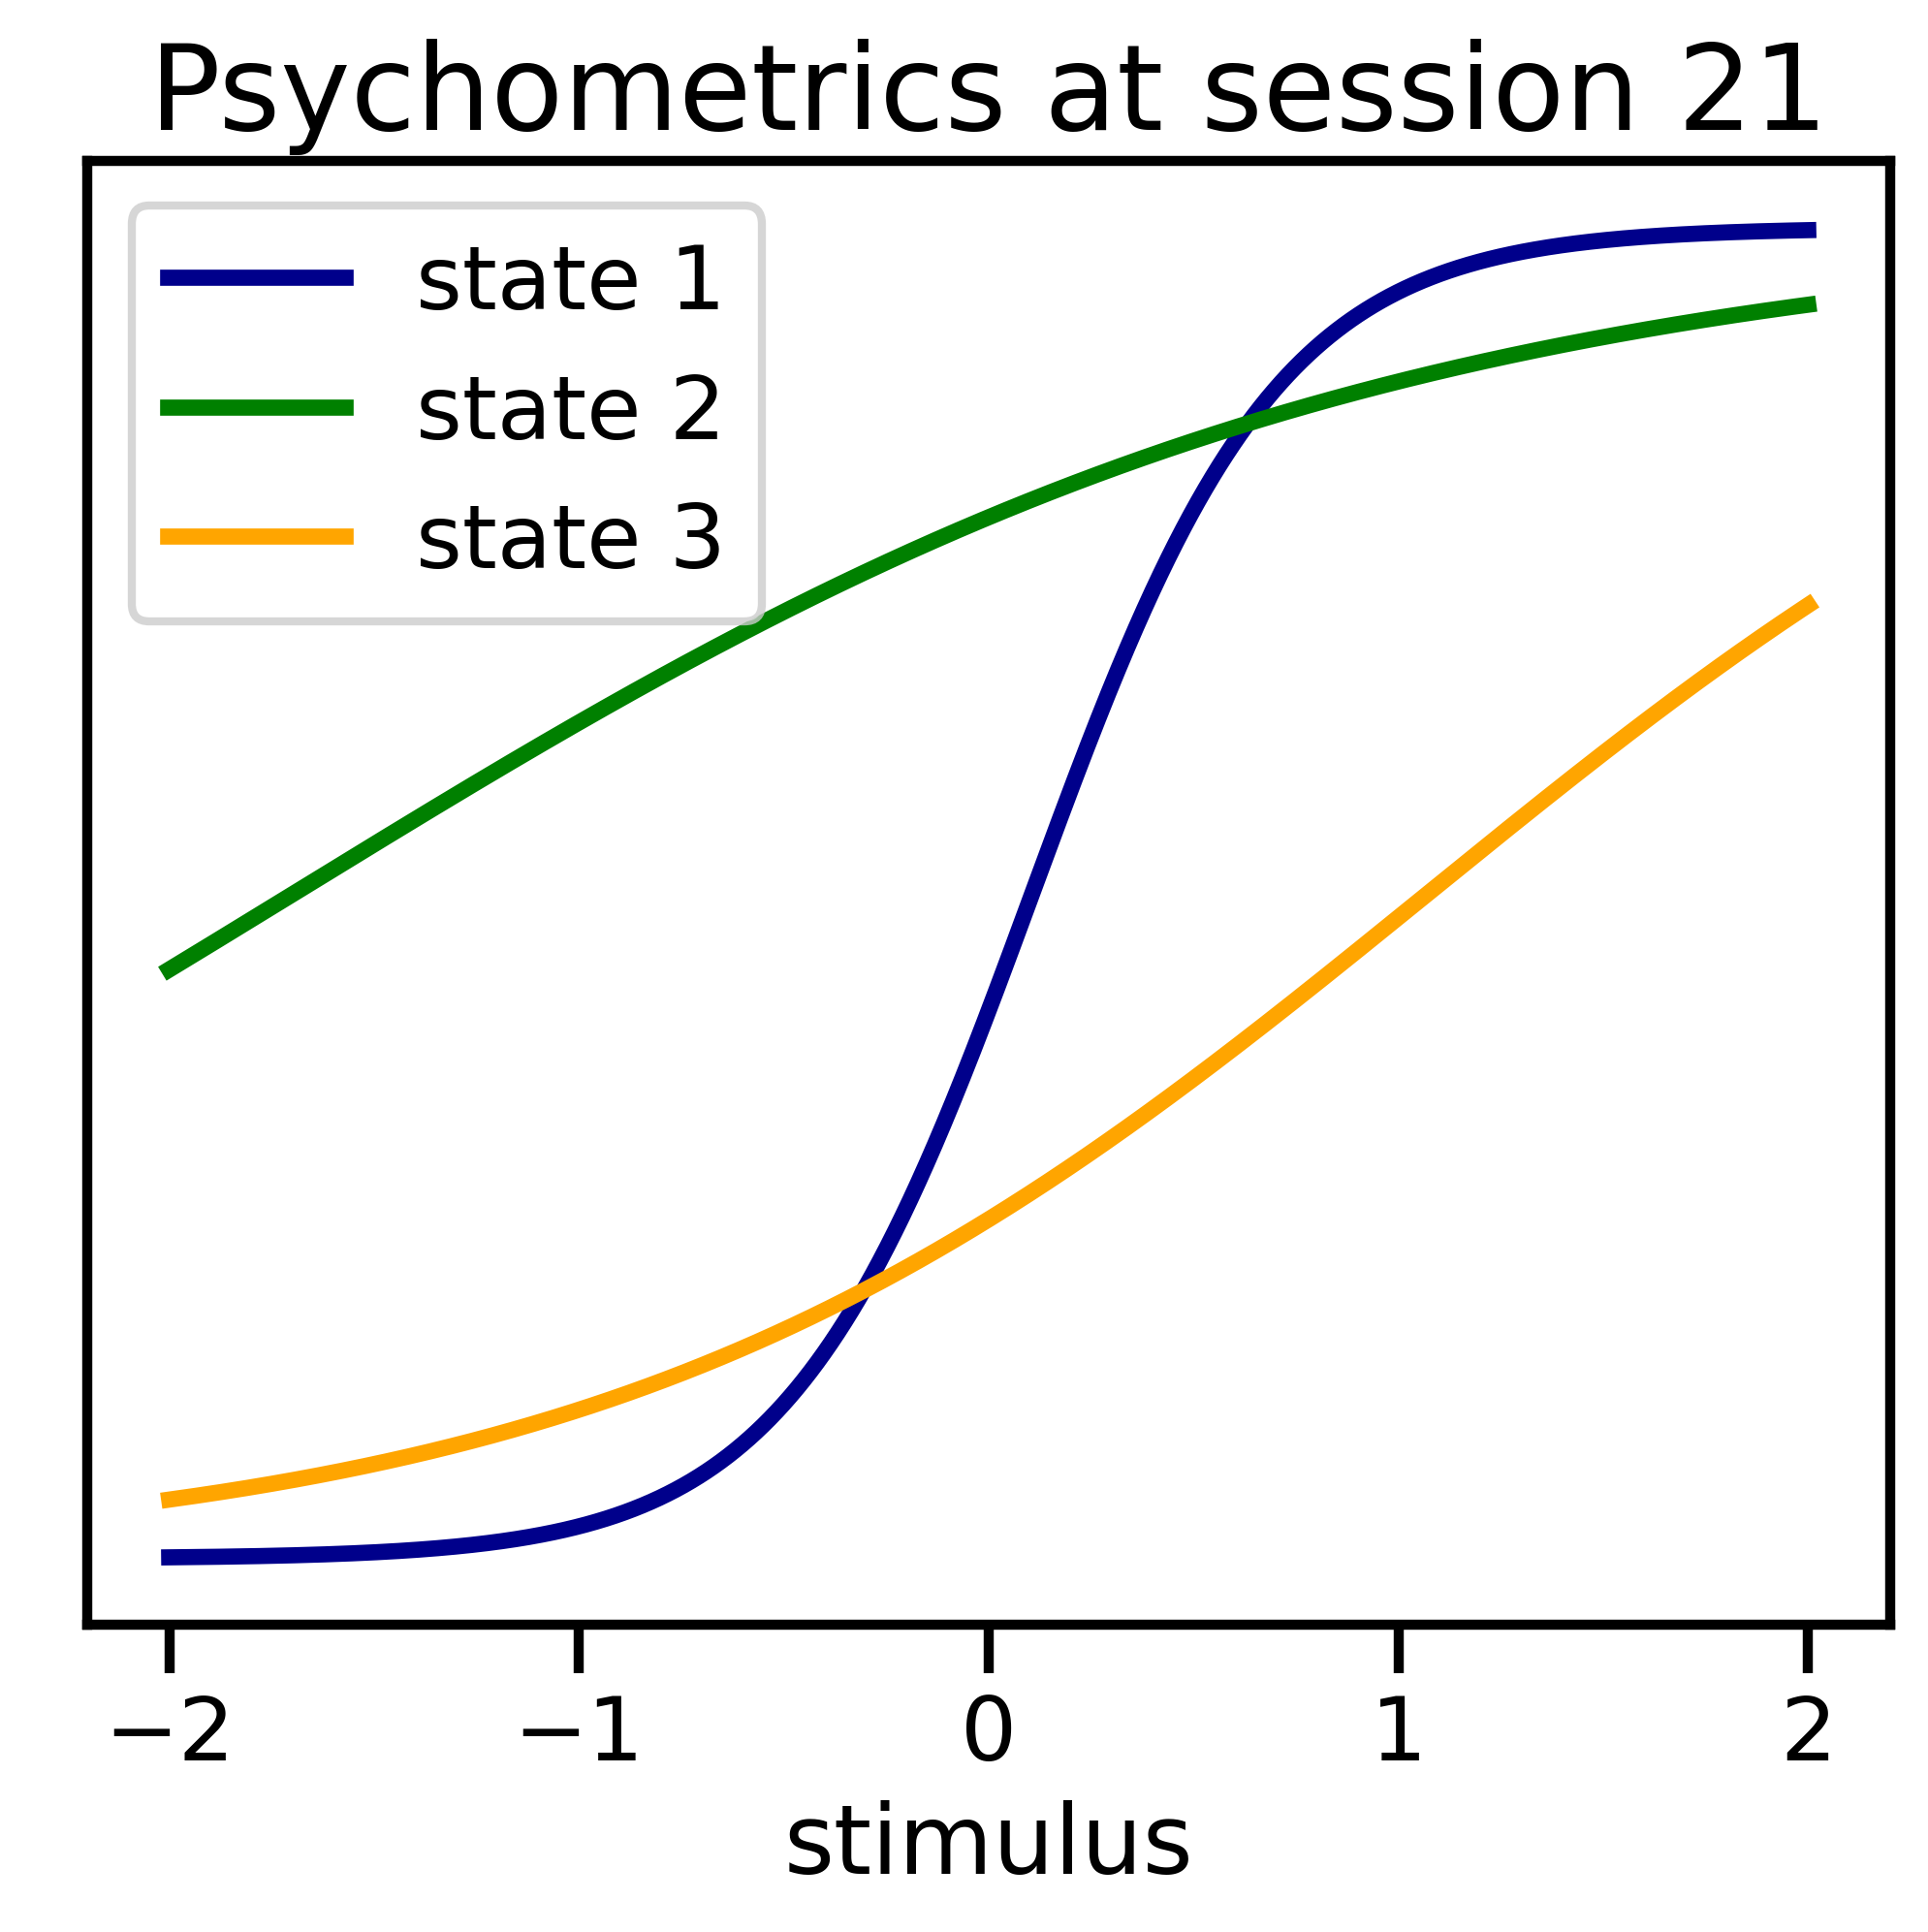

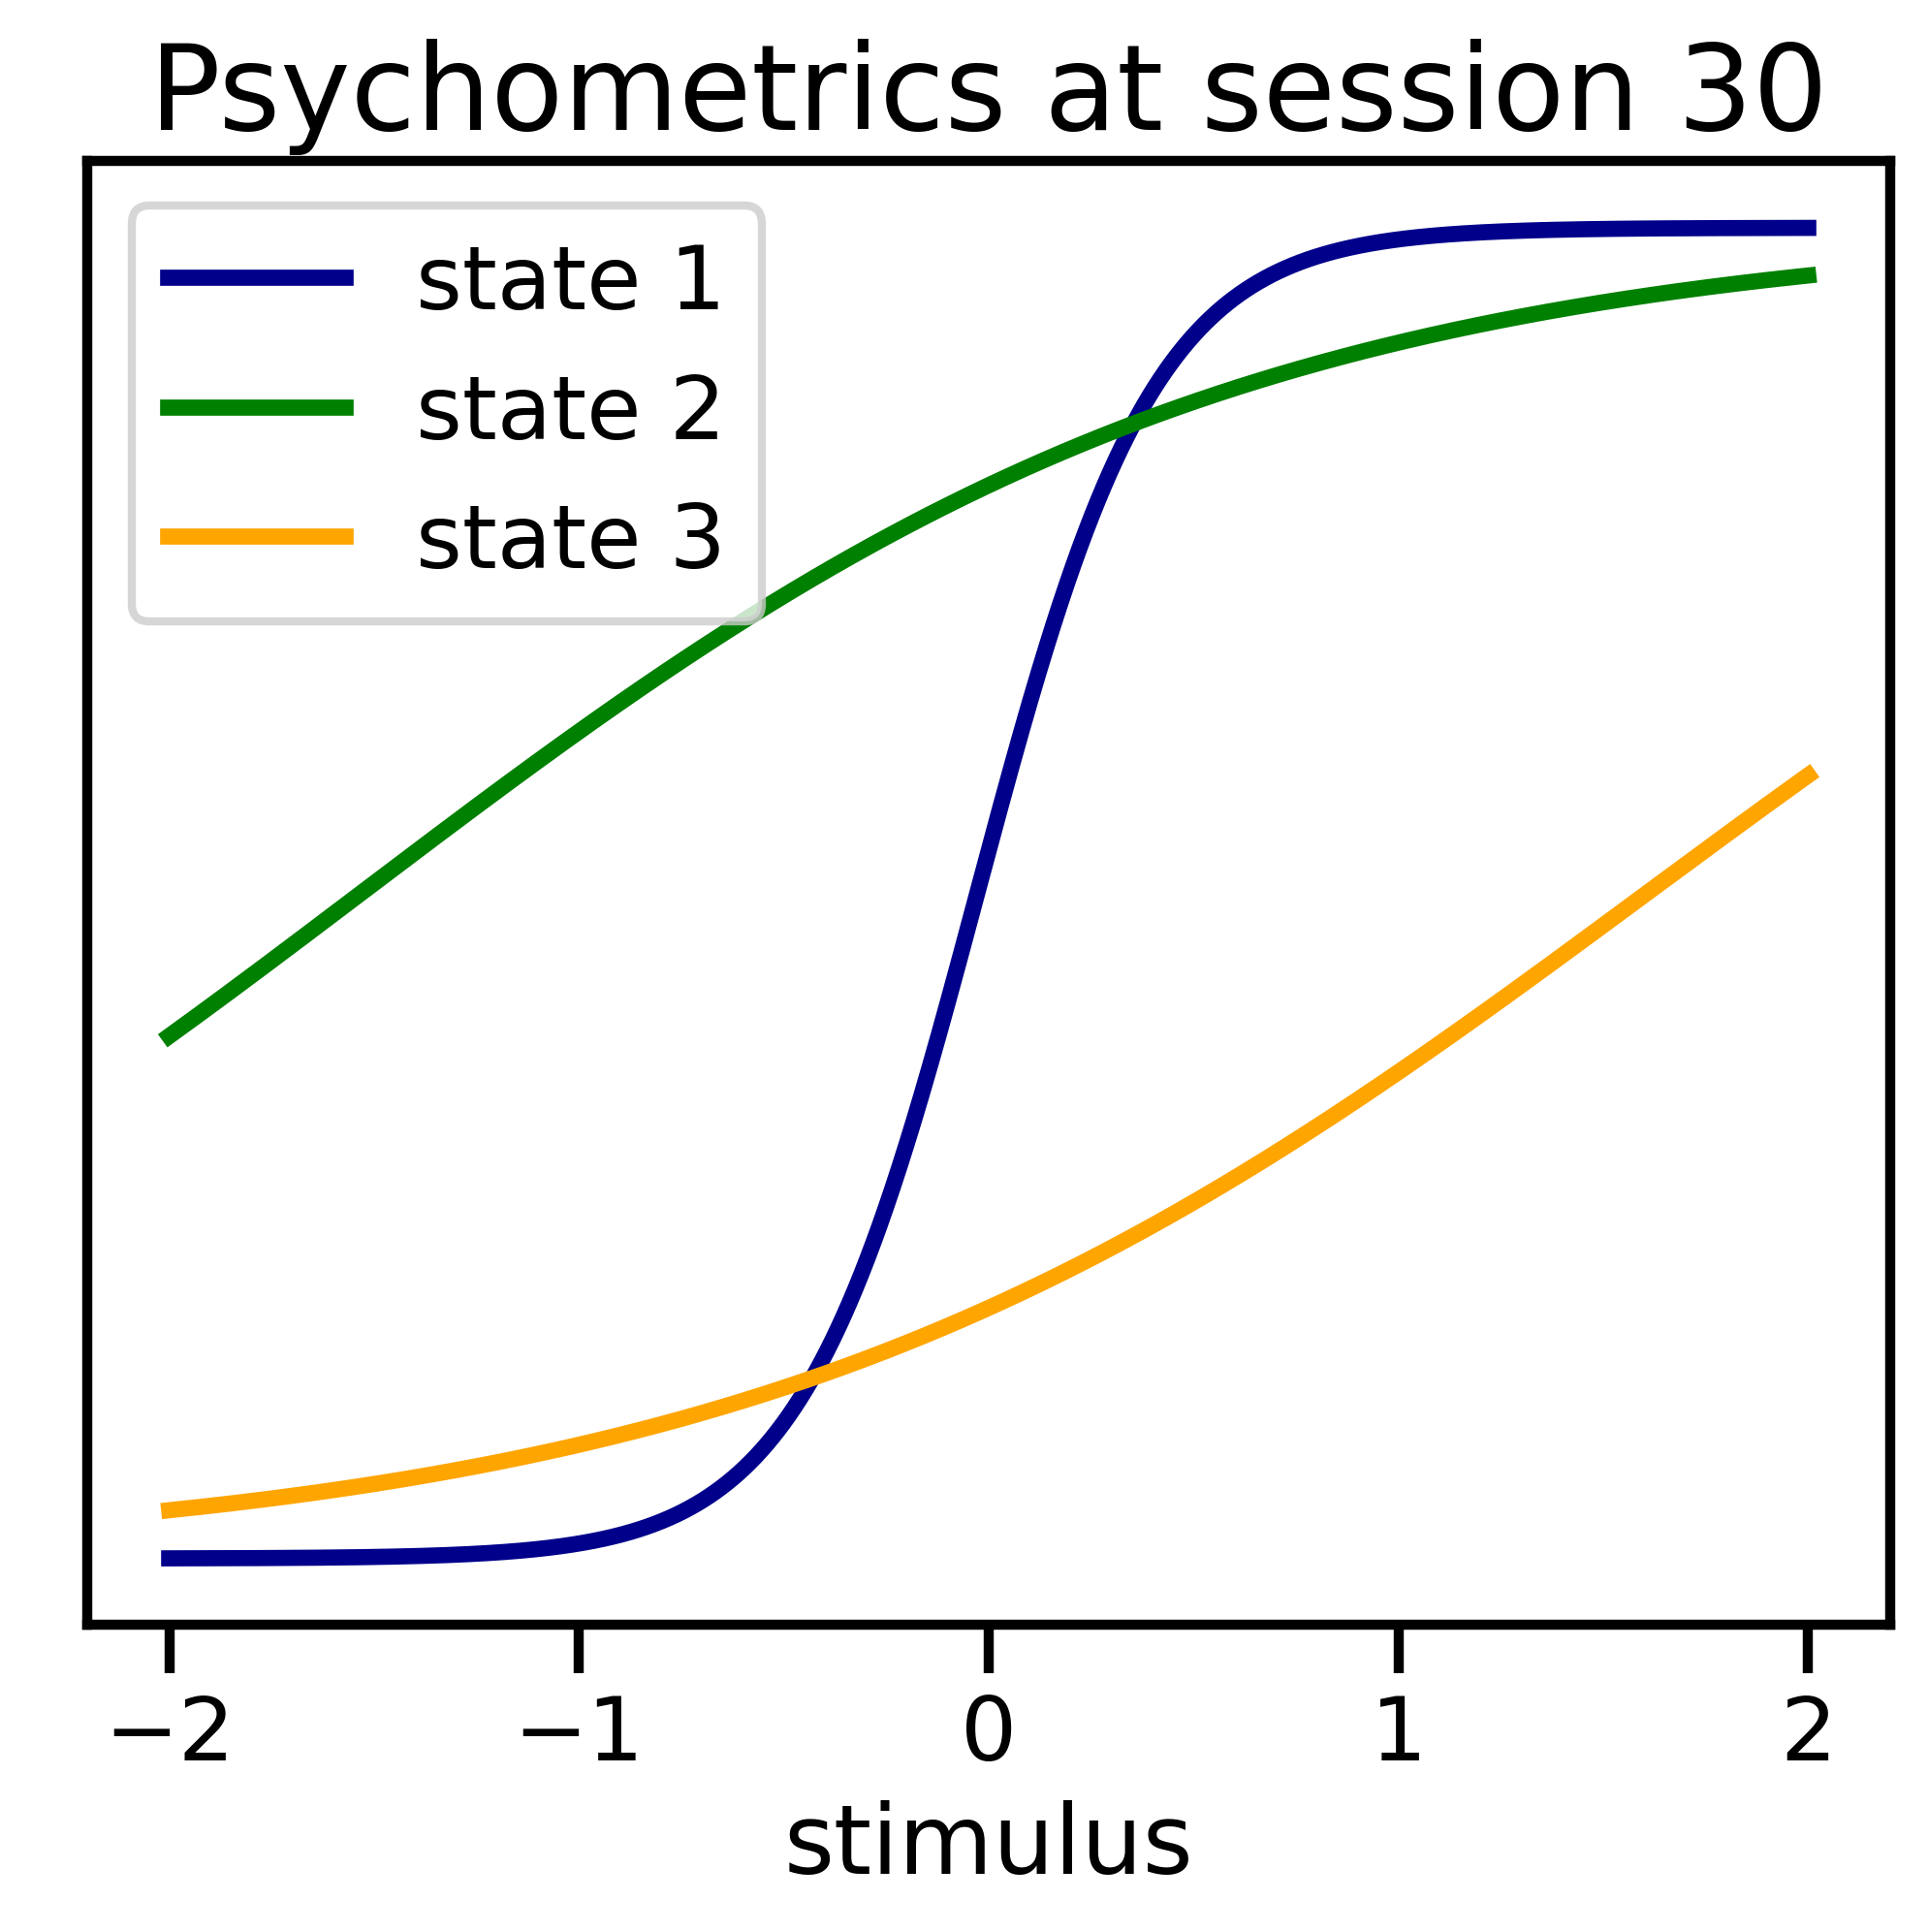

In [74]:
for session in sessionsInterest:
    fig, axes = plt.subplots(figsize=(6,5), dpi=400)
    plotting_psychometric(-avgW[bestSigmaInd], sessInd, session, axes, colorsStates)
    axes.set_title(f'Psychometrics at session {session+1}', fontsize=22)
    axes.set_xlabel('stimulus')
    if (session != 9):
        axes.set_ylabel('')
        axes.set_yticks([])

Text(-66.79166666666669, 0.5, '% task accuracy ')

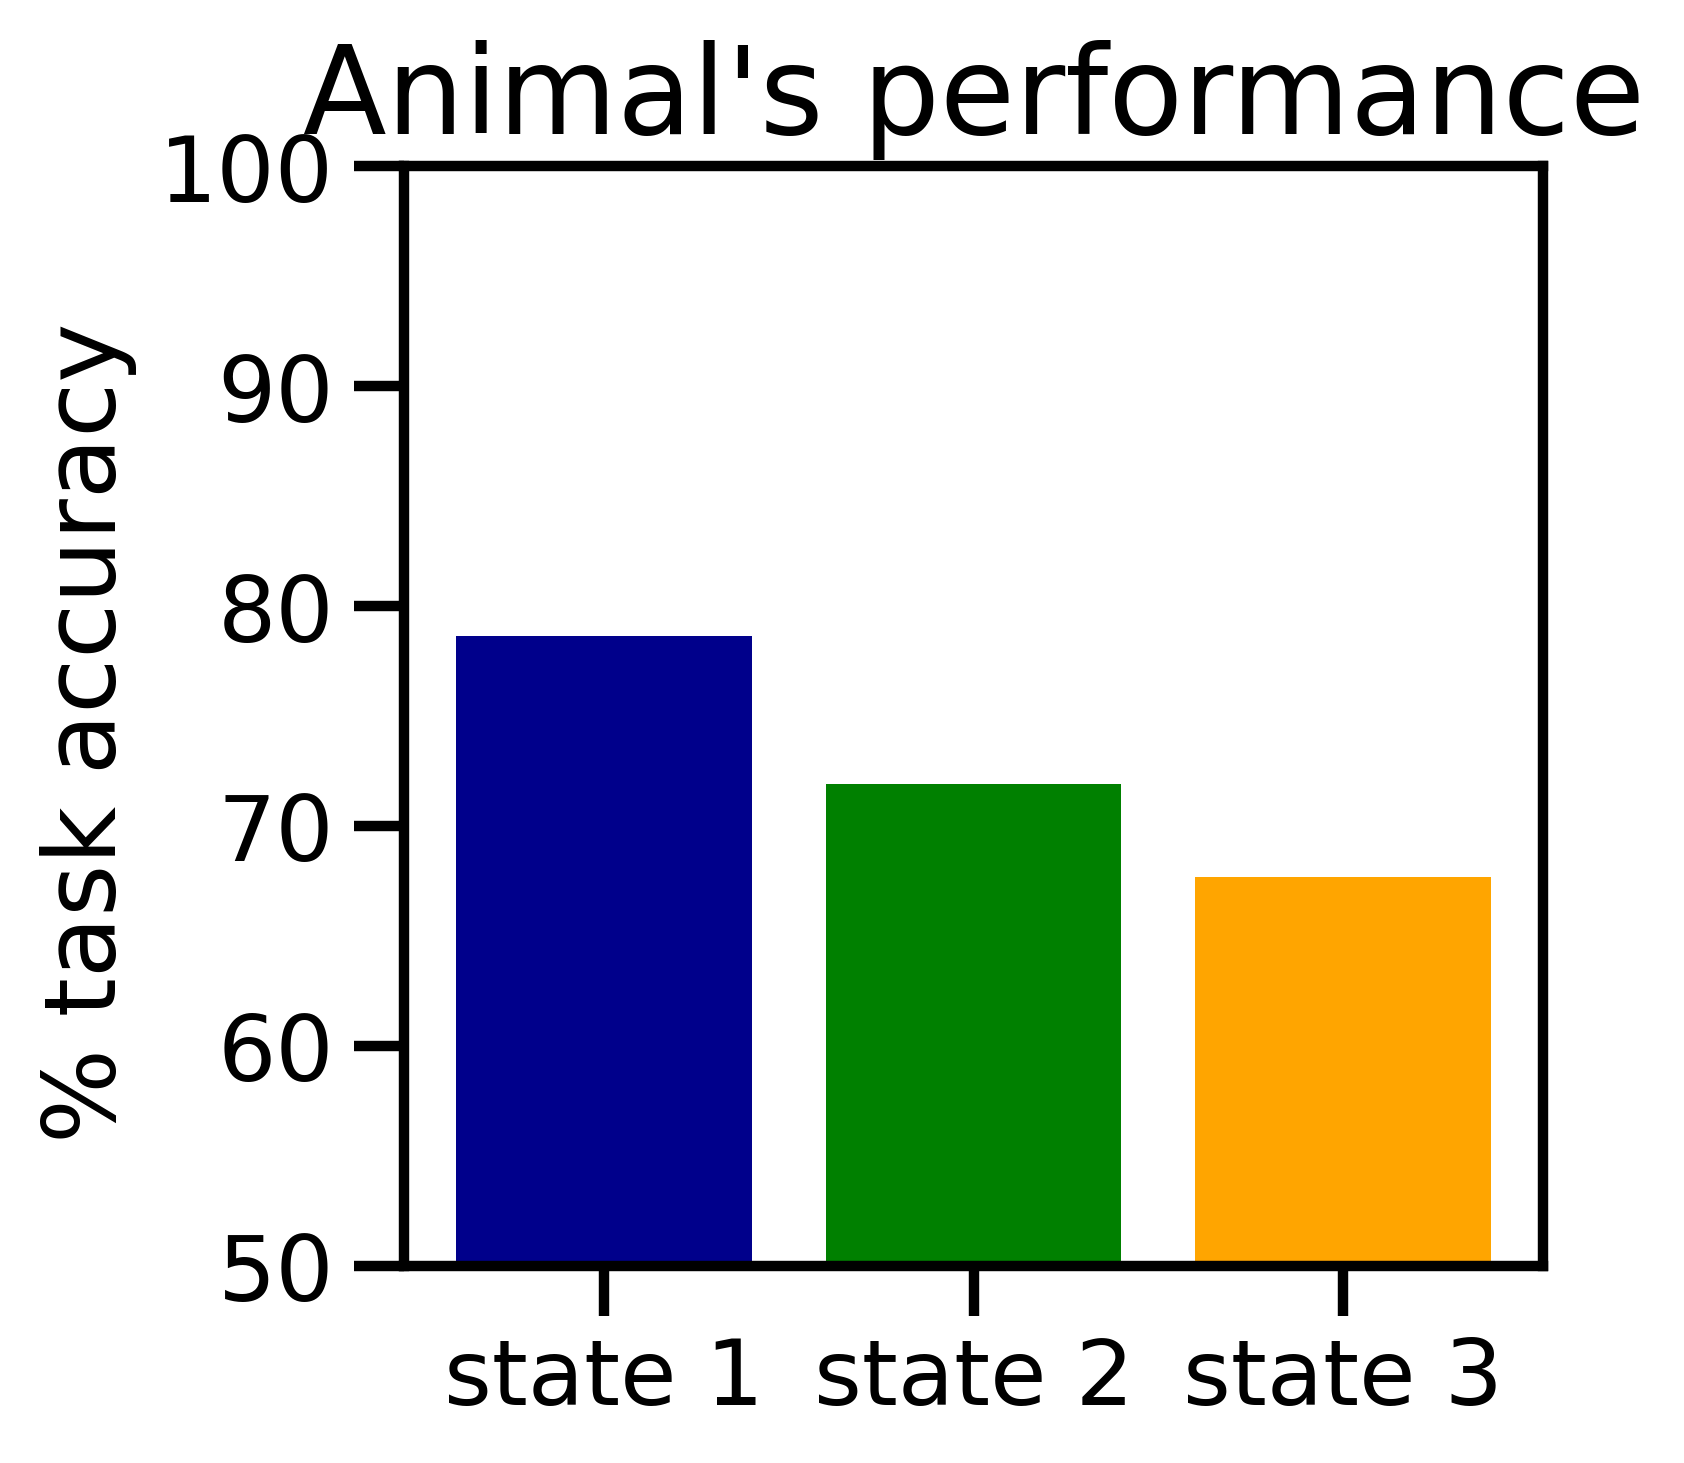

In [72]:
# Plotting animal's task accuracy in each state

x, y, sessInd = get_mouse_design(dfAll, exampleSubject, sessStop=sessStop, D=4)
N = sessInd[-1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,2)
present = np.ones((N))
gamma = dGLM_HMM.get_posterior_latent(avgP[bestSigmaInd], truepi, avgW[bestSigmaInd], x, y, present, sessInd, sortedStateInd=None)
data = dfAll[dfAll['subject']==exampleSubject]   # Restrict data to the subject specified
dateToKeep = np.unique(data['date'])[0:sessStop]
dataTemp = pd.DataFrame(data.loc[data['date'].isin(list(dateToKeep))]).reset_index(drop=True)
correctSide = np.array(dataTemp['correctSide'])
choiceHard = np.argmax(gamma, axis=1)
correct = np.zeros((K))
for t in range(0, choiceHard.shape[0]):
    if (correctSide[t] == y[t]):
        correct[choiceHard[t]] += 1
for k in range(0,K):
    correct[k] = correct[k] / np.where(choiceHard == k)[0].shape[0] * 100
fig, axes = plt.subplots(1, figsize = (4,4), dpi=400)
axes.bar(['state 1','state 2','state 3'], correct, color=colorsStates)
axes.set_title("Animal's performance", fontsize=22)
axes.set_ylim(50,100)
fig.tight_layout()
axes.set_ylabel('% task accuracy ')